# <center>  Capstone Project - Coursera

<center> <img src = 'https://upload.wikimedia.org/wikipedia/commons/thumb/3/3a/Sacramento_Regional_Transit.svg/150px-Sacramento_Regional_Transit.svg.png'>

# Introduction/Business Problem

Sacramento is home to a light rail system operated by the Sacramento Regional Transit. Their main customers are work commuters. For non-commuters the light rail is less popular. To improve ridership outside of the normal work-commute, the light rail system should promote popular destinations that are close to the light rail. Marketing by Sacramento Regional Transit that highlights the most popular destinations near the light rail could increase the appeal of taking light rail and increase ridership. This information would also be important for people visiting Sacramento, such as guests to the new hotel near the University and 65th St light rail station. Currently, there is no information on main attractions in proximity to light rail stations. Data science tools can quickly compile this information from the Internet to create new marketing materials to improve ridership.

<img src = 'http://www.sacrt.com/schedules/maps/R507.gif'>

# Data

Light rail station locations and data from Foursquare, a website that collects venue information, will be used to provide the best-rated destinations in proximity to the light rail. Locations of the light rail stations come from the Sacramento Area Council of Governments (SACOG), which has a data repository available to the public. The light-rail station locations are shown in the Appendix. (http://data-sacog.opendata.arcgis.com/datasets/66dbe2e5407a443aa019f21839d4ebde_0) Information on venues within a half-mile (800 meters) radius from each light rail station will be collected by an “explore-call” to Foursquare’s API for each light rail location. Calls for each venue in the Foursquare API will be used to compile each venue’s rating.

## Import Libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#import geocoders
#pip install geopy
#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import geopy.distance

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

#import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

import matplotlib.pyplot as plt; plt.rcdefaults()
import matplotlib.pyplot as plt

print('Libraries imported.')

Libraries imported.


## Import data on light rail stations

In [2]:
# source url of data http://data-sacog.opendata.arcgis.com/datasets/66dbe2e5407a443aa019f21839d4ebde_0
df_stations=pd.read_csv('/home/clif/Downloads/Light_Rail_Stops.csv')
df_stations.head()

# Remove unnecessary fields - X, Y, OBJECTID, ID, STATION
df_stations.drop(['X','Y','OBJECTID', 'ID', 'STATION'],axis=1, inplace=True)

# There are duplicate light rail stations. Identify and remove these stations/records

# Removed duplicate stations listed amd reset the index of new dataframe
df_stations.drop_duplicates(['DISPLAY'],keep='first',inplace=True)
df_stations.reset_index(drop=True, inplace=True)
df_stations.shape

# reorganize columns to dataframe
df_stations=df_stations[['DISPLAY','POINT_Y','POINT_X']]

# rename columns
df_stations.rename(index=str, \
                   columns={'DISPLAY':'Station', 'POINT_X':'Longitude', 'POINT_Y' : 'Latitude'},\
                   inplace=True)

# rename train stations with incorrect names
df_stations.loc[df_stations['Station'] == 'Frranklin Blvd', ['Station']] = 'Franklin Blvd'
df_stations.loc[df_stations['Station'] == 'Cosumbes River College', ['Station']] = 'Cosumnes River College'
df_stations.loc[df_stations['Station'] == 'Morrison Creek - cnstrc', ['Station']] = 'Morrison Creek'

# remove Station 8th 7 K
df_stations = df_stations[df_stations.Station != '8th 7 K']

# review stations in dataset
df_stations.sort_values(by='Station', inplace=True)
df_stations.reset_index(drop=True, inplace=True)
df_stations

,Station,Latitude,Longitude
0,12th & I,38.581450,-121.489901
1,13th Street,38.571112,-121.493731
2,16th Street,38.569836,-121.489329
3,23rd Street,38.566692,-121.478992
4,29th Street,38.564645,-121.471397
5,39th Street,38.560764,-121.457246
6,47th Ave,38.511909,-121.475913
7,48th Street,38.558512,-121.449025
8,4th Ave/Wayne Hultgren,38.551589,-121.488083
9,59th Street,38.554650,-121.435527


## Compile Venue Data From Foursquare

Use Foursquare to bring in data on local venues.<br>
First define Foursquare credentials

In [3]:
# Four-Square Credentials
CLIENT_ID = 'JIVUEWG3G04BL5MZ1Y0FCOXQ5LEQDWNWZ0UEIVT5Q1VIHDI0' # your Foursquare ID
CLIENT_SECRET = 'PDOYIMEWSCZSZVZCYM2Y2ID4V4RHQWQ0YCCH1FAHZTSXP344' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

Create a function to get nearby venues from location

In [4]:
# Create a function to get nearby venues from the light rail stations

LIMIT = 100 # limit number of venues returned by Foursquare API
radius = 800 # define radius to get all venues within one-half mile from zip code location
def getNearbyVenues(names, latitudes, longitudes, radius=radius):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['id'],
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Station', 
                  'Station Latitude', 
                  'Station Longitude',
                  'ID',
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [5]:
# retrieve venues near light rail stations from Foursquare
station_venues = getNearbyVenues(names=df_stations['Station'],
                                   latitudes=df_stations['Latitude'],
                                   longitudes=df_stations['Longitude']
                                  )

12th & I
13th Street
16th Street
23rd Street
29th Street
39th Street
47th Ave
48th Street
4th Ave/Wayne Hultgren
59th Street
7th & Capitol
7th & I
7th & K
8th & Capitol
8th & H
8th & K
8th & O
9th & K
Alkali Flats
Archives Plaza
Arden/Del Paso
Broadway
Butterfield
Cathedral Square
Center Parkway
City College
College Greens
Cordova Town Center
Cosumnes River College
Florin
Franklin Blvd
Fruitridge
Glenn
Globe
Hazel
Historic Folsom
Iron Point
Marconi
Mather Field/Mills
Meadowview
Morrison Creek
Power Inn
Roseville Road
Royal Oaks
Sac Valley
Starfire
Sunrise
Swanston
Tiber
Township 9
University/65th St
Watt/I-80
Watt/Manlove
Zinfandel


In [6]:
# remove Light Rail venues
station_venues = station_venues[station_venues['Venue Category'] != 'Light Rail Station']\
.reset_index(drop=True)

# Review data table's top 5 records
print(station_venues.shape)
station_venues.head()

(2399, 8)


,Station,Station Latitude,Station Longitude,ID,Venue,Venue Latitude,Venue Longitude,Venue Category
0,12th & I,38.58145,-121.489901,4b9ad151f964a520b7d835e3,Miosa Bride,38.579924,-121.491045,Bridal Shop
1,12th & I,38.58145,-121.489901,4aefa08af964a520a7d921e3,Ella Dining Room & Bar,38.578660,-121.491275,American Restaurant
2,12th & I,38.58145,-121.489901,4add393af964a520a96421e3,Grange,38.580256,-121.493670,New American Restaurant
3,12th & I,38.58145,-121.489901,4bbcd46f8ec3d13a6d4a1b28,Bangkok@12,38.580594,-121.490342,Thai Restaurant
4,12th & I,38.58145,-121.489901,53c6b927498ee83c5b56d33c,Mother,38.578966,-121.493134,Vegetarian / Vegan Restaurant


## Compile Venue Rating Data

In [7]:
# create dataframe with distinct venues to compile ratings for each venue
print('station_venues dimensions', station_venues.shape)
unique_venues = station_venues['ID'].unique()
unique_venues = pd.DataFrame(data=unique_venues,columns=['ID'])
unique_venues.shape

station_venues dimensions (2399, 8)


(1104, 1)

In [ ]:
# Rating Calls are Premium Calls and are Limited to 500 in a day. Therefore calls had to be made over multiple days. 
# Results from each call were saved to csv format then appended together to make one table
# generate venue ratings list
venue_ratings_list=[]
for x in range(0,500):
    try:
        venue_ratings_list.append({'ID': df_missing['ID'][x], 
                                  'Rating': requests.get('https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'\
.format(df_missing['ID'][x], CLIENT_ID, CLIENT_SECRET, VERSION)).json()['response']['venue']['rating']})
    except:
        venue_ratings_list.append({'ID': df_missing['ID'][x], 'Rating': 'NaN'})

In [ ]:
# generate a dataframe from venue ratings list
Ratings_1 = pd.DataFrame(venue_ratings_list)

# send dataframe to csv to save
Ratings_1.to_csv('VenueRatings_1.csv',index=False)

In [8]:
# append multiple ratings files
Ratings_Final = pd.read_csv('VenueRatings_0.csv')\
.append(pd.read_csv('VenueRatings_1.csv'),sort=True)
Ratings_Final = Ratings_Final.append(pd.read_csv('VenueRatings_2.csv'),sort=True)
Ratings_Final = Ratings_Final.append(pd.read_csv('VenueRatings_3.csv'),sort=True)
Ratings_Final = Ratings_Final.append(pd.read_csv('VenueRatings_missing.csv'),sort=True)\
.reset_index(drop=True)
Ratings_Final = Ratings_Final.append(pd.read_csv('VenueRatings_missing2.csv'),sort=True)\
.reset_index(drop=True)
print(Ratings_Final.shape)

(1736, 3)


In [9]:
# The first Venue Rating pulls had duplicate venue ID's and need to be removed
# match Rating Venues to Station Venues then drop duplicate venue ratings, 
# reset index and find shape

Ratings_Final = Ratings_Final.merge(unique_venues, on='ID', how='inner')
Ratings_Final = Ratings_Final.sort_values(by = ['ID','Rating'], ascending=False)\
.drop_duplicates(['ID'])
print('Ratings_Final dimensions', Ratings_Final.shape)
Ratings_Final.head()

Ratings_Final dimensions (1102, 3)


,ID,Rating,Venue
687,5caa0a71f1936e002cf603c8,7.2,NaN
583,5c807afd835c9a002c0bbc34,6.5,NaN
473,5c15671be55d8b002c4153b3,7.5,NaN
940,5c06da61535d6f002b4edeb4,8.5,NaN
109,5c00add4fdb9a7003933097e,7.7,Pressed Juicery


# Methodology

Let's see the distribution of Venue Ratings within one-half mile from the light rail system.

Text(0.5, 1.0, 'Number of Venues that Received Each Rating')

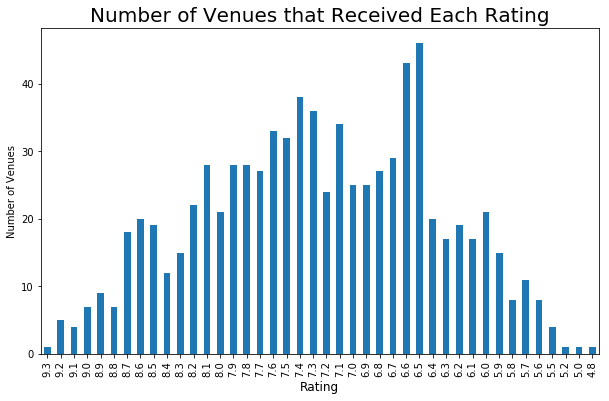

In [10]:
# create bar graph of rating frequencies
import matplotlib.pyplot as plt
Ratings_Final['Rating'].value_counts().sort_index(ascending=False).plot(kind='bar', figsize = (10,6))
plt.xlabel('Rating', fontsize = 12)
plt.ylabel('Number of Venues')
plt.title('Number of Venues that Received Each Rating', fontsize=20)

In [11]:
Ratings_Final['Rating'].describe()

count    806.000000
mean       7.262655
std        0.870658
min        4.800000
25%        6.600000
50%        7.300000
75%        7.900000
max        9.300000
Name: Rating, dtype: float64

Chart 1, above, shows a bar graph of the number of venues that received each rating. Ratings ranged from a high of 9.3 to a low of 4.8. A statistical summary of ratings is shown below that. After removing unrated venues, there are 808 venues counted. The mean average rating is 7.26 and the median is 7.3.

### Adding Ratings and Distance to the Station Venues Table

In [12]:
# Add venue ratings to station dataframe
station_venues = station_venues.merge(Ratings_Final[['ID','Rating']],\
                                      left_on = 'ID', right_on = 'ID', how='inner')
print(station_venues.shape)
station_venues.head()

(2397, 9)

Run a loop that measures distance between each record's venue and station

In [13]:
# calculate distances between light rail station and venues
venue_distance_list=[]
for x in range(len(station_venues['ID'])):
#    try:
        coords_1 = (station_venues['Station Latitude'][x],\
                               station_venues['Station Longitude'][x])
        coords_2 = (station_venues['Venue Latitude'][x],\
                               station_venues['Venue Longitude'][x])
        venue_distance_list.append({'ID': station_venues['ID'][x], \
                                    'Station': station_venues['Station'][x],\
                                    'Distance': geopy.distance.distance(coords_1, coords_2).miles})

In [14]:
# create data frame from venue distances then add venue distance to station venues dataframe
df_venue_distance=pd.DataFrame(venue_distance_list)
print(df_venue_distance.shape)

station_venues['Distance'] = df_venue_distance['Distance']
station_venues['Rating'] = station_venues['Rating'].astype(str)
station_venues.head()

(2397, 3)


,Station,Station Latitude,Station Longitude,ID,Venue,Venue Latitude,Venue Longitude,Venue Category,Rating,Distance
0,12th & I,38.581450,-121.489901,4b9ad151f964a520b7d835e3,Miosa Bride,38.579924,-121.491045,Bridal Shop,9.2,0.122108
1,7th & Capitol,38.578333,-121.498680,4b9ad151f964a520b7d835e3,Miosa Bride,38.579924,-121.491045,Bridal Shop,9.2,0.427699
2,7th & I,38.582659,-121.496810,4b9ad151f964a520b7d835e3,Miosa Bride,38.579924,-121.491045,Bridal Shop,9.2,0.364698
3,7th & K,38.580024,-121.497950,4b9ad151f964a520b7d835e3,Miosa Bride,38.579924,-121.491045,Bridal Shop,9.2,0.373897
4,8th & Capitol,38.577472,-121.497785,4b9ad151f964a520b7d835e3,Miosa Bride,38.579924,-121.491045,Bridal Shop,9.2,0.402228


In [15]:
# keep unique venue with shortest distance to station entry
station_venues_dist = station_venues.sort_values(['ID','Distance']).drop_duplicates(subset = 'ID', keep='first').reset_index(drop=True)

# remove records of venues that do not have a venue rating
station_venues_dist = station_venues_dist[station_venues_dist.Rating != 'nan']

# review the shape of the table
print(station_venues_dist.shape)
station_venues_dist.head()

(806, 10)


,Station,Station Latitude,Station Longitude,ID,Venue,Venue Latitude,Venue Longitude,Venue Category,Rating,Distance
0,12th & I,38.581450,-121.489901,48277a7cf964a520b84f1fe3,P.F. Chang's,38.577967,-121.485585,Chinese Restaurant,8.1,0.335092
1,29th Street,38.564645,-121.471397,4841301ff964a52033501fe3,Ink Eats & Drinks,38.569311,-121.471378,American Restaurant,8.6,0.321851
2,23rd Street,38.566692,-121.478992,48413066f964a52034501fe3,Q St. Bar and Grill (Benny's),38.568995,-121.482730,Bar,7.4,0.257315
3,16th Street,38.569836,-121.489329,484131b0f964a52037501fe3,Naked Lounge,38.570627,-121.489873,Café,8.0,0.062009
4,23rd Street,38.566692,-121.478992,4846f0c7f964a52071501fe3,Old Tavern Bar & Grill,38.570808,-121.482641,Dive Bar,6.1,0.345927


### Create a Map of the Venues In Proximity of Light Rail

In [16]:
# Using Location to Properly Center Map

address = 'Rancho Cordova, CA'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude-.008
longitude = location.longitude
print('The geograpical coordinate of Rancho Cordova, CA are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Rancho Cordova, CA are 38.581072299999995, -121.302728.


In [17]:
# Map light rail stations and the top ranked venues color-coordinated by station of closest proximity

map_stations = folium.Map(location=[latitude, longitude], zoom_start=10.5, #tiles='Stamen Toner')
                         )

for lat, lon, venue, station, venue_cat, rating in zip(station_venues_dist['Venue Latitude'],\
                            station_venues_dist['Venue Longitude'],\
                            station_venues_dist['Venue'],\
                            station_venues_dist['Station'],\
                            station_venues_dist['Venue Category'],\
                            station_venues_dist['Rating']):
    
    label = folium.Popup(html=(venue + ' - ' +
                         str(rating)  + ' - ' + station + ' - ' + venue_cat), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=1,
        popup=label,
        fill=True,
        fill_color='green',
        clustered_marker = True,
        fill_opacity=0.05).add_to(map_stations)



for lat, lon, station in zip(df_stations['Latitude'], \
                                  df_stations['Longitude'], \
                                  df_stations['Station']):
    label = ('<strong>' + (station) + '<br>' + ' Station' + '</strong>')
    folium.CircleMarker(
        [lat, lon],
        radius=1,
        popup=label,
        color='black',
        fill=True,
        fill_opacity=0.7).add_to(map_stations)
       
map_stations

# Results

In the Results section, we will review the venues and stations that Sacramento’s Regional Transit would want to promote as top destinations provided by the light rail.

In [20]:
# review top ranked venues 
top_venues = station_venues_dist[station_venues_dist.Rating.astype(float) >= 8.8].sort_values(by = 'Station')
top_venues = top_venues[['Venue', 'Station', 'Venue Category', 'Rating', 'Distance']]
top_venues['Distance'] = top_venues['Distance'].round(2)
top_venues = top_venues.sort_values(by=['Rating','Station'], ascending=False).set_index('Venue')
top_venues

,Station,Venue Category,Rating,Distance
Venue,,,,
Crocker Art Museum,7th & Capitol,Art Museum,9.3,0.44
Miosa Bride,Cathedral Square,Bridal Shop,9.2,0.10
Capitol Park,Archives Plaza,Park,9.2,0.21
Sacramento Natural Foods Co-op,29th Street,Grocery Store,9.2,0.07
The Sandwich Spot,16th Street,Sandwich Place,9.2,0.18
Old Soul Co.,16th Street,Coffee Shop,9.2,0.45
Ella Dining Room & Bar,Cathedral Square,American Restaurant,9.1,0.06
California State Capitol,Archives Plaza,Capitol Building,9.1,0.15
Golden 1 Center,7th & K,Basketball Stadium,9.1,0.09


The table above lists the top-rated venues, represented by venues with ratings of 8.8 or greater. The table is sorted in descending order by venue rating, where the best-rated venue is listed first. Regional Transit should promote these venues as light rail destinations to current and potential riders. The top venues include the Crocker Art Museum, Capitol Park, a grocery store called the Natural Foods Co-Op, a coffee shop Old Soul Co., a restaurant called Ella Dining Room & Bar, the State Capitol and the new arena for the Sacramento Kings called the Golden 1 Center. Building partnerships with these businesses could help improve ridership numbers for the light rail.

### Graph Top Venues Color Coordinated By Station

In [21]:
# Get distinct stations from the top-rated venues from previous table made
Stations_dist = pd.DataFrame(top_venues['Station'].unique(), columns=['Stations'])

# Set a variety of distinct colors for mapping by distinct station
colors = ['silver','rosybrown','firebrick','sandybrown','gold', 'olivedrab', 'charteuse', 'seagreen', \
          'darkcyan', 'navy', 'mediumvioletred', 'orange', 'brown', 'chocolate', 'royal blue', 'darkblue' ]

# Add colors randomly to list of distinct stations with top rated venues
Stations_dist['colors']=colors

# Create Dataframe top_venues_map for mapping the top-rated venues by light rail station
top_venues_map = station_venues_dist[station_venues_dist.Rating.astype(float) >= 8.8].sort_values(by = 'Station')

# Merge colors and location info
top_venues_map = top_venues_map.merge(Stations_dist, left_on = 'Station', right_on = 'Stations', how = 'left')
top_venues_map


,Station,Station Latitude,Station Longitude,ID,Venue,Venue Latitude,Venue Longitude,Venue Category,Rating,Distance,Stations,colors
0,12th & I,38.581450,-121.489901,4b0586b9f964a520766b22e3,Mikuni,38.577707,-121.485507,Sushi Restaurant,8.9,0.351068,12th & I,darkblue
1,13th Street,38.571112,-121.493731,555e4fc2498e2877db2bd0e1,Bottle & Barlow,38.570889,-121.494917,Salon / Barbershop,8.9,0.066023,13th Street,mediumvioletred
2,13th Street,38.571112,-121.493731,5452ad26498e2e8f461d877b,South,38.568665,-121.496962,Southern / Soul Food Restaurant,9.0,0.243062,13th Street,mediumvioletred
3,16th Street,38.569836,-121.489329,4bc8c4218b7c9c741ede38cf,The Sandwich Spot,38.569851,-121.486016,Sandwich Place,9.2,0.179439,16th Street,gold
4,16th Street,38.569836,-121.489329,4b26fc81f964a520c58324e3,Zuda Yoga,38.571311,-121.483682,Yoga Studio,8.8,0.322283,16th Street,gold
5,16th Street,38.569836,-121.489329,4b1d832ff964a5208a1124e3,Zocalo,38.574137,-121.483771,Mexican Restaurant,9.0,0.422615,16th Street,gold
6,16th Street,38.569836,-121.489329,4a99c08bf964a5204b3020e3,Old Soul Co.,38.574911,-121.484246,Coffee Shop,9.2,0.445303,16th Street,gold
7,16th Street,38.569836,-121.489329,4a99bd40f964a520303020e3,Uncle Vito's Slice of NY,38.572282,-121.487794,Pizza Place,8.8,0.188114,16th Street,gold
8,29th Street,38.564645,-121.471397,4b0586b9f964a520386b22e3,Sacramento Natural Foods Co-op,38.564475,-121.472676,Grocery Store,9.2,0.070260,29th Street,sandybrown
9,29th Street,38.564645,-121.471397,524a2a4c11d24d26e4632e9e,Lou's Sushi,38.567286,-121.471919,Sushi Restaurant,8.8,0.184310,29th Street,sandybrown


In [22]:
# Since most of the top-rated venues are in the downtown area, we will center this map in that area

address = 'Sacramento, CA'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude-.01
longitude = location.longitude+.01
print('The geograpical coordinate of Sacramento, CA are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Sacramento, CA are 38.5715719, -121.48439959999999.


In [23]:
# Create the map of light rail stations and the top ranked venues color-coordinated by station of closest proximity

map_stations = folium.Map(location=[latitude, longitude], zoom_start=13.49, #tiles='Stamen Toner')
                         )
for lat, lon, station in zip(df_stations['Latitude'], \
                                  df_stations['Longitude'], \
                                  df_stations['Station']):
    label = folium.Popup(str(station) + ' Station', parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=1,
        popup=label,
        color='black',
        fill=True,
        fill_opacity=0.7).add_to(map_stations)
    
for lat, lon, venue, station, venue_cat, rating, color in zip(top_venues_map['Venue Latitude'],\
                            top_venues_map['Venue Longitude'],\
                            top_venues_map['Venue'],\
                            top_venues_map['Station'],\
                            top_venues_map['Venue Category'],\
                            top_venues_map['Rating'],\
                            top_venues_map['colors']):

    label = folium.Popup(venue + ' - ' + rating + ' - ' + station + ' - ' + venue_cat, parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=2,
        popup =  label ,
        color=color,
        fill=True,
        clustered_marker = True,
        fill_opacity=0.05).add_to(map_stations)
       
map_stations

Interactive maps that display recommended venues where the venue’s name, category, nearest light rail station and venue rating appear when the marker is clicked on can provide helpful information to riders. There is a large group of recommended venues in the downtown area. The map above displays the venues on the “Grid” in Sacramento that have a rating of 8.8 or higher. Each marker color represents a specific light rail station.

## Top Venue Categories

In [25]:
station_venues_dist.loc[station_venues_dist.Rating.astype(float) >= 8.8].groupby('Venue Category').count().sort_values('Rating',ascending=False)

,Station,Station Latitude,Station Longitude,ID,Venue,Venue Latitude,Venue Longitude,Rating,Distance
Venue Category,,,,,,,,,
Coffee Shop,3,3,3,3,3,3,3,3,3
American Restaurant,2,2,2,2,2,2,2,2,2
Grocery Store,2,2,2,2,2,2,2,2,2
Sushi Restaurant,2,2,2,2,2,2,2,2,2
New American Restaurant,2,2,2,2,2,2,2,2,2
Vegetarian / Vegan Restaurant,1,1,1,1,1,1,1,1,1
Southern / Soul Food Restaurant,1,1,1,1,1,1,1,1,1
Sandwich Place,1,1,1,1,1,1,1,1,1
Salon / Barbershop,1,1,1,1,1,1,1,1,1


The table above shows the variety of destinations the light rail has to provide among its highest rated venues (venue ratings of 88 or greater). Many of the destinations are around food and beverage venues. There are also museums, fitness, and entertainment options.

### Analyzing Stations by Top Five Rated Venues in Proximity

Another way to present destinations for light rail riders is to promote individual light rail stations. This can be done by grouping the top five venues for each light rail station then promoting the stations that have the best-rated venues. The table below lists the top five venues near each station, sorted by the mean average rating of the top five venues near each light rail station where the stations with the best rated venues are listed first. Regional Transit should promote stations with the highest average ratings, and ignore those with the lowest scores. There are also five stations not in the table. Four of these stations did not have a rated venue within a half-mile of the light rail station. There is one station at Capitol and 8th St where all the venues within a half-mile were closer to another light rail station.

In [26]:
# Create a Dataframe of the top 5 rated venues at each station

# Make Rating a float
station_venues_dist.Rating = station_venues_dist.Rating.astype('float')

# group by station and pull the top 5 rated venues for each station
df_top5bystation=station_venues_dist.groupby('Station')['Rating'].nlargest(5).reset_index()

# merge top 5 station for each station to station_venue information - merge on 'level_1'
df_top5bystation.columns
df_top5bystation=df_top5bystation.merge(station_venues_dist, left_on='level_1', right_index = True, how='inner')

# cleanup dataframe
df_top5bystation=df_top5bystation[['Station_x','Venue', 'Venue Category', 'Rating_x', 'Distance',\
                                   'Venue Latitude','Venue Longitude']].\
rename(columns={'Station_x': 'Station','Rating_x':'Rating'})
df_top5bystation[['Station','Venue','Venue Category', 'Rating', 'Distance']]

,Station,Venue,Venue Category,Rating,Distance
0,12th & I,Mikuni,Sushi Restaurant,8.9,0.351068
1,12th & I,Sacramento Theatre Company,Theater,8.4,0.211930
2,12th & I,The Torch Club,Nightclub,8.2,0.235116
3,12th & I,P.F. Chang's,Chinese Restaurant,8.1,0.335092
4,12th & I,Lucca Restaurant & Bar,Mediterranean Restaurant,8.1,0.370707
5,13th Street,South,Southern / Soul Food Restaurant,9.0,0.243062
6,13th Street,Bottle & Barlow,Salon / Barbershop,8.9,0.066023
7,13th Street,Dad's Sandwiches,Sandwich Place,8.6,0.146099
8,13th Street,Urban Roots Brewing & Smokehouse,Brewery,8.6,0.385378
9,13th Street,Fox & Goose Public House,Pub,8.3,0.175853


Mapping stations by average venue ratings of the top 5 venues

In [28]:
df_stationrating = pd.DataFrame(df_top5bystation.groupby('Station')['Rating'].mean())
df_stationrating.Rating = df_stationrating.Rating.round(2)
df_stationrating.sort_values(by='Rating', ascending = False, inplace=True)
df_stationrating = df_stationrating.merge(df_stations[['Station','Latitude','Longitude']], on='Station', how='right')
df_stationrating.fillna(0)

,Station,Rating,Latitude,Longitude
0,16th Street,9.00,38.569836,-121.489329
1,Cathedral Square,8.92,38.578855,-121.492340
2,29th Street,8.86,38.564645,-121.471397
3,4th Ave/Wayne Hultgren,8.82,38.551589,-121.488083
4,Sac Valley,8.72,38.584416,-121.499643
5,Historic Folsom,8.72,38.675963,-121.180572
6,8th & K,8.70,38.579778,-121.496732
7,9th & K,8.70,38.579548,-121.495488
8,13th Street,8.68,38.571112,-121.493731
9,Broadway,8.64,38.559568,-121.488015


In [29]:
# add colors based on station ratings values

df_stationrating.loc[df_stationrating['Rating'] < 6.5, 'color'] = 'red'
df_stationrating.loc[df_stationrating['Rating'] >= 6.5, 'color'] = 'orange'
df_stationrating.loc[df_stationrating['Rating'] >= 7.0, 'color'] = 'gold'
df_stationrating.loc[df_stationrating['Rating'] >= 7.5, 'color'] = 'yellow'
df_stationrating.loc[df_stationrating['Rating'] >= 8.0, 'color'] = 'greenyellow'
df_stationrating.loc[df_stationrating['Rating'] >= 8.5, 'color'] = 'limegreen'
df_stationrating.loc[df_stationrating['Rating'].isnull(), 'color'] = 'red'



In [30]:
# Create Map of station rating

address = 'Rancho Cordova, CA'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude-.008
longitude = location.longitude

map_stations = folium.Map(location=[latitude, longitude], zoom_start=10.5, #tiles='Stamen Toner')
                         )
for lat, lon, station, color, rating in zip(df_stationrating['Latitude'], \
                                  df_stationrating['Longitude'], \
                                  df_stationrating['Station'], \
                                  df_stationrating['color'],
                                  df_stationrating['Rating']):
    label = folium.Popup(str(station) + ' Station' + ' - ' + str(rating), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=4,
        popup=label,
        color=color,
        fill=True,
        #fill_color=rainbow[station-1],
        fill_opacity=0.7).add_to(map_stations)
map_stations

The map above highlights the stations that have the best rated destinations. The stations with the best-rated destinations are in green, stations with mid-ranged rated venues are yellow and the stations with the worst rated destinations are in red. The station rating is based on the mean average of the five best venues within one-half mile of the light rail station.

Max Rating 9.0 Min Rating 6.0 Range 3.0


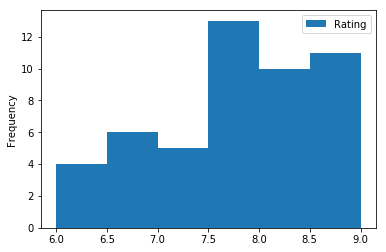

In [31]:
# Create a Histogram of the station ratings - the average of the top 5 rated venues near each station

df_stationrating[['Station','Rating']].plot.hist(bins=6)
print('Max Rating', df_stationrating.Rating.max(), 'Min Rating',df_stationrating.Rating.min(),\
      'Range', df_stationrating.Rating.max() - df_stationrating.Rating.min())

In [32]:
#Presenting each of the top 5 rated venues by light rail station sorted with the top rated station first and in descending order

df_top5rpt = df_top5bystation.merge(df_stationrating[['Station','Rating']], on='Station', how='inner')\
.rename(columns={'Rating_y':'Station Rating', 'Rating_x':'Venue Rating'})\
.sort_values(by=['Station Rating','Station'], ascending=False).drop(['Venue Latitude','Venue Longitude'],axis = 1)\
.set_index(['Station','Station Rating'])
df_top5rpt.Distance = df_top5rpt.Distance.round(2)
df_top5rpt

Venue  \
Station                Station Rating                                                 
16th Street            9.00                                            Old Soul Co.   
                       9.00                                       The Sandwich Spot   
                       9.00                                                  Zocalo   
                       9.00                                Uncle Vito's Slice of NY   
                       9.00                                               Zuda Yoga   
Cathedral Square       8.92                                             Miosa Bride   
                       8.92                                  Ella Dining Room & Bar   
                       8.92                                                  Mother   
                       8.92                                           Cafeteria 15L   
                       8.92                                              Pizza Rock   
29th Street            8.86                          Sacramento Natural Foods Co-op   
                       8.86                                     Temple Coffee & Tea   
                       8.86                                             Lou's Sushi   
                       8.86                                       Ink Eats & Drinks   
                       8.86                                                    Biba   
4th Ave/Wayne Hultgren 8.82                                         Taylor's Market   
                       8.82                                           Dad's Kitchen   
                       8.82                                         Freeport Bakery   
                       8.82                               Oscar's Very Mexican Food   
                       8.82                                          Marie's Donuts   
Sac Valley             8.72                        California State Railroad Museum   
                       8.72                                The Firehouse Restaurant   
                       8.72                                            Evangeline's   
                       8.72                                          Old Sacramento   
                       8.72                        Rocky Mountain Chocolate Factory   
Historic Folsom        8.72                                   Karen's Bakery & Cafe   
                       8.72                                   Samuel Horne's Tavern   
                       8.72                              Snooks Candies & Ice Cream   
                       8.72                                             Marly & Moo   
                       8.72                             The Fat Rabbit Public House   
9th & K                8.70                                     Temple Coffee & Tea   
                       8.70                                                  Grange   
                       8.70                                       Coin-Op Game Room   
                       8.70                 The Citizen Hotel, Autograph Collection   
                       8.70                                            Bud's Buffet   
8th & K                8.70                                             Frank Fat's   
13th Street            8.68                                                   South   
                       8.68                                         Bottle & Barlow   
                       8.68                                        Dad's Sandwiches   
                       8.68                        Urban Roots Brewing & Smokehouse   
                       8.68                                Fox & Goose Public House   
Broadway               8.64                                              Tower Cafe   
                       8.64                         Queen Sheba Ethopian Restaurant   
                       8.64                                           Tower Theatre   
                       8.64                                               Su

# Discussion

This exercise shows there are many destinations that Regional Transit can promote to improve ridership. This information used by a marketing team could entice more people to ride the light rail to improve ridership.

Regional Transit can take this information to improve the perceived value of the light rail. The light rail provides convenient transit to these destinations that include top-rated restaurants, museums, bars, grocery stores, fitness centers, and more by simply hopping on the light rail to enjoy at one’s leisure, on the weekend, or after work.

Each station has its own personality shown by this guide of highly rated venues near the light rail stations.

Come downtown to enjoy a concert or basketball game at the new arena, some fine dining at a new popular restaurant called Mother, without worrying about parking or having a designated driver.

# Conclusion

Sacramento’s light rail system lacks popularity because there is little knowledge provided about popular destinations riders can enjoy by riding. Each station has its own special opportunities to enjoy at one’s leisure. However, riders are not aware of them. With this exercise, we are able to provide riders, guests, and residents the opportunities for having a fun night just by taking the light rail train and not having to worry about parking. The information could entice people to visit a new area of Sacramento to enjoy what it has to offer, from Historic Folsom to downtown, and to south Sacramento’s Broadway and Curtis Park areas, and everything in between. When someone is looking for something new to do in Sacramento they could get the idea from Regional Transit with knowledge it’s attainable by riding the light rail.